In [2]:
import os
import math
import gc

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline

In [3]:
application_train = pd.read_csv('data/application_train.csv')
application_test = pd.read_csv('data/application_test.csv')
bureau = pd.read_csv('data/bureau.csv')
bureau_balance = pd.read_csv('data/bureau_balance.csv')
credit_card_balance = pd.read_csv('data/credit_card_balance.csv')
installments_payments = pd.read_csv('data/installments_payments.csv')
POS_CASH_balance = pd.read_csv('data/POS_CASH_balance.csv')
previous_application = pd.read_csv('data/previous_application.csv')

In [3]:
file_names = os.listdir('data')[1:]
file_names.remove('application_train.csv')
file_names.insert(0, 'application_train.csv')

print(file_names)

['application_train.csv', 'application_test.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'target_cv.csv', 'test_cv.csv', 'train_cv.csv']


In [4]:
df_list = [application_train, application_test, bureau, bureau_balance, credit_card_balance, installments_payments, POS_CASH_balance ,previous_application]

In [5]:
for file_name_and_file in zip(file_names, df_list):
    print('{} shape: {}'.format(file_name_and_file[0], np.shape(file_name_and_file[1])))

application_train.csv shape: (307511, 122)
application_test.csv shape: (48744, 121)
bureau.csv shape: (1716428, 17)
bureau_balance.csv shape: (27299925, 3)
credit_card_balance.csv shape: (3840312, 23)
installments_payments.csv shape: (13605401, 8)
POS_CASH_balance.csv shape: (10001358, 8)
previous_application.csv shape: (1670214, 37)


# 1. application_train analysis

In [6]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
def missing_value_counter(DataFrame):
    print('The following features are missing values: \n')
    for column in DataFrame.columns:
        if DataFrame[column].isna().value_counts()[0] < len(DataFrame):
            no_missing = len(DataFrame) - DataFrame[column].isna().value_counts()[0]
            print('{} missing value counts: {}, {:.5f}% of column missing'.format(column, no_missing, no_missing/len(DataFrame[column])))

In [8]:
missing_value_counter(application_train)

The following features are missing values: 

AMT_ANNUITY missing value counts: 12, 0.00004% of column missing
AMT_GOODS_PRICE missing value counts: 278, 0.00090% of column missing
NAME_TYPE_SUITE missing value counts: 1292, 0.00420% of column missing
OWN_CAR_AGE missing value counts: 202929, 0.65991% of column missing
OCCUPATION_TYPE missing value counts: 96391, 0.31346% of column missing
CNT_FAM_MEMBERS missing value counts: 2, 0.00001% of column missing
EXT_SOURCE_1 missing value counts: 173378, 0.56381% of column missing
EXT_SOURCE_2 missing value counts: 660, 0.00215% of column missing
EXT_SOURCE_3 missing value counts: 60965, 0.19825% of column missing
APARTMENTS_AVG missing value counts: 156061, 0.50750% of column missing
BASEMENTAREA_AVG missing value counts: 179943, 0.58516% of column missing
YEARS_BEGINEXPLUATATION_AVG missing value counts: 150007, 0.48781% of column missing
YEARS_BUILD_AVG missing value counts: 204488, 0.66498% of column missing
COMMONAREA_AVG missing value c

Lets first look at the distribution of the target

Text(0.5,1,'Distribution of Target')

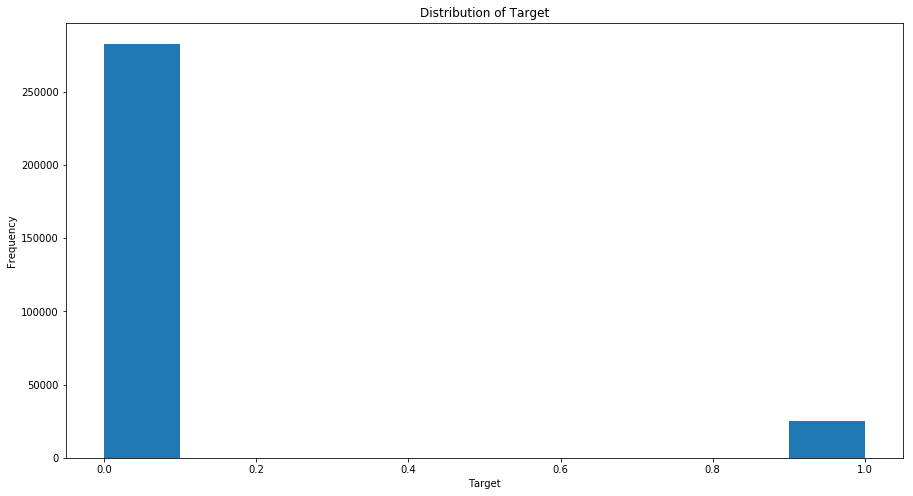

In [9]:
plt.subplots(figsize = (15, 8))
plt.hist(application_train['TARGET'])
plt.ylabel('Frequency')
plt.xlabel('Target')
plt.title('Distribution of Target')

There is a clear class imbalance in the target so the model will be trained on skewed data which contains mostly records of people that could not pay back their loans. This means accuracy likely won't be a great metric also so AUROC, as will be used to later evaluate the model, is a better metric instead.

Plotting correlation between some of the numerical columns in the training dataset:

In [10]:
heatmap_list = ['TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
                'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
                'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
                'OWN_CAR_AGE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

In [11]:
def correlation_map(df, columns, figsize=(15,10)):
    correlation = (df.loc[:, columns]).corr()

    fig, ax = plt.subplots(figsize = figsize)
    sns.heatmap(correlation, annot = True, ax = ax)

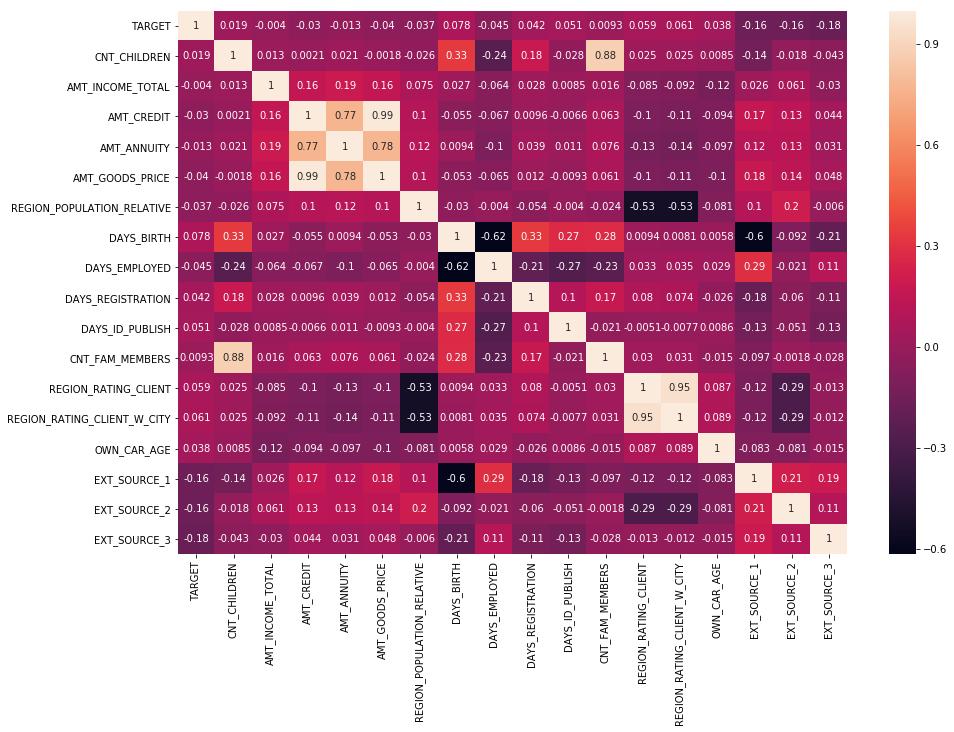

In [12]:
correlation_map(application_train, heatmap_list)

The three external sources features show some correlation with a number of features which means those features may be used to calculate these external source ratings. There is also some correlation between CNT_CHILDREN and DAYS_BIRTH. Interesting to note that REGION_RATING_CLIENT and REGION_RATING_CLIENT_W_CITY show a relatively high negative correlation with REGION_POPULATION_RELATIVE - meaning that the rating of the client's region is generally lower (I'm assuming this means better) the more people live in that region.

Looking at the correlation of each of the features with the target:

In [13]:
target_corr = application_train.corr()['TARGET'].sort_values()

In [14]:
print(target_corr.head(20))
print()
print(target_corr.tail(20))

EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
ELEVATORS_MEDI               -0.033863
FLOORSMIN_AVG                -0.033614
FLOORSMIN_MEDI               -0.033394
LIVINGAREA_AVG               -0.032997
LIVINGAREA_MEDI              -0.032739
FLOORSMIN_MODE               -0.032698
TOTALAREA_MODE               -0.032596
ELEVATORS_MODE               -0.032131
LIVINGAREA_MODE              -0.030685
AMT_CREDIT                   -0.030369
Name: TARGET, dtype: float64

OBS_30_CNT_SOCIAL_CIRCLE       0.009131
CNT_FAM_MEMBERS                0.009308
CNT_CHILDREN                   0.019187
AMT_REQ_CREDIT_BUREAU_YEAR     0.019930
FLAG_WORK_PHONE               

The three external ratings EXT_SOURCE_1, 2, and 3 are somewhat negatively correlated with the target and the most positively correlated feature is REGION_RATING_CLIENT_W_CITY. However, none of the features have any significant correlation with the target.

From above, we know that the EXT_SOURCE features all contain a varying range of missing values with EXT_SOURCE_2 having, by far, the lowest number of NaN values

Looking at the correlation between the external sources, the target, and some other features:

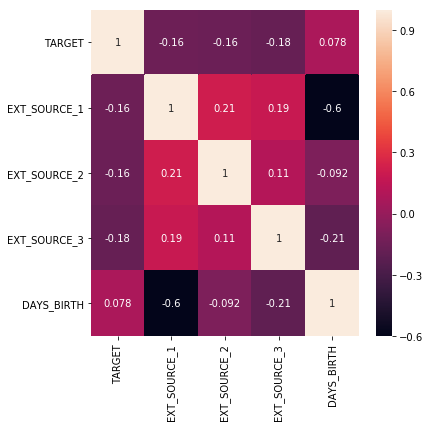

In [15]:
correlation_map(application_train, ['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'], (6,6))

EXT_SOURCE_1 and DAYS_BIRTH show a correlation meaning that age is likely a factor in the creation of the EXT_SOURCE_1 rating for applicants. These features will all likely be important for our model in prediction. Looking at a pairplot of these features:

/anaconda3/envs/home-credit-test/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/envs/home-credit-test/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/envs/home-credit-test/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/envs/home-credit-test/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/envs/home-credit-test/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/envs/home-credit-test/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'l

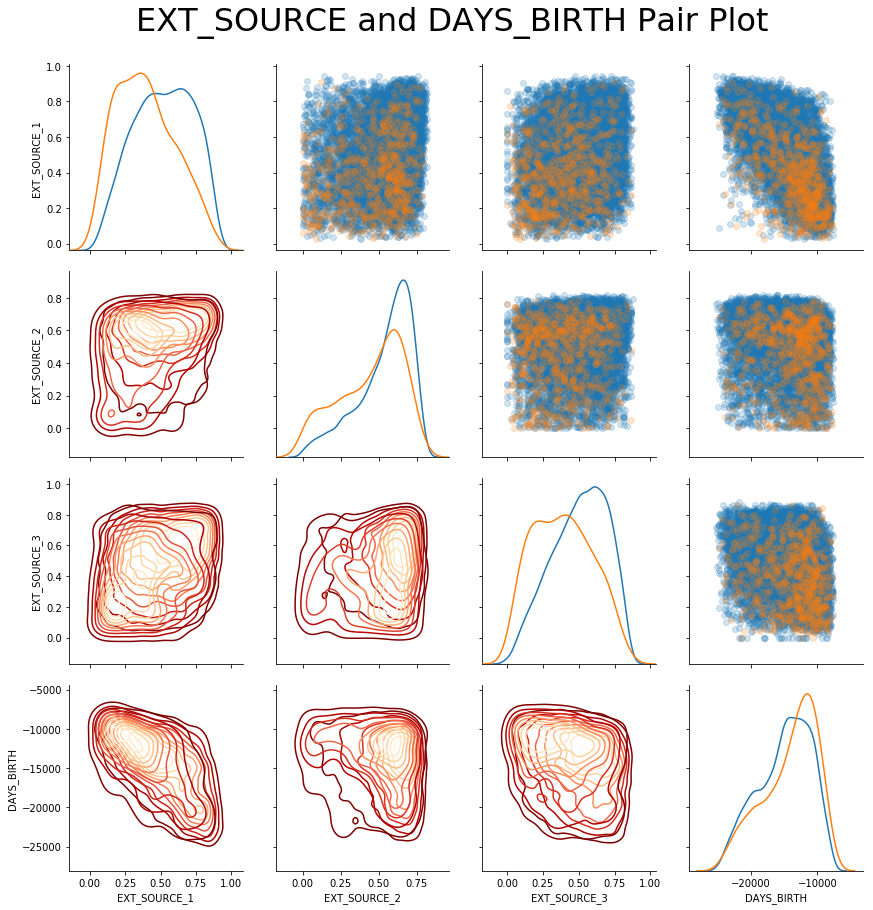

In [16]:
# Copy the data for plotting
plot_data = application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
                               'EXT_SOURCE_3', 'DAYS_BIRTH']].copy()

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().sample(10000)#.loc[:100000, :]

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

grid.map_upper(plt.scatter, alpha = 0.2)
grid.map_diag(sns.kdeplot)
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);
plt.suptitle('EXT_SOURCE and DAYS_BIRTH Pair Plot', size = 32, y = 1.05);

Looking at the relationships between DAYS_BIRTH and the three EXT_SOURCEs, we can see the concentration of orange points in each plot where applicants did repay their loan and the blue points where applicants did not repay their loan. There is a small correlation between DAYS_BIRTH and EXT_SOURCE_1 as previously mentioned. EXT_SOURCE_1 here appears to be a good predictor for ability to repay with a clear difference in KDE plots between those who could repay (orange hue) having a high density around 0.25 and those that couldn't repay (blue) having a high density around 0.5 but it should be noted that this feature possesses 173378 missing values. To put this in perspective:

In [17]:
EXT_SOURCE_1_miss = 173378/len(application_train['EXT_SOURCE_1'])

In [18]:
print('Percentage of missing values in EXT_SOURCE_1: {:.2f}%'.format(EXT_SOURCE_1_miss))

Percentage of missing values in EXT_SOURCE_1: 0.56%


So this is not a reliable feature since it is often missing. EXT_SOURCE_3 shows a similar distribution so if we look at the missing values there:

In [19]:
EXT_SOURCE_3_miss = 60965/len(application_train['EXT_SOURCE_3'])

In [20]:
print('Percentage of missing values in EXT_SOURCE_3: {:.2f}%'.format(EXT_SOURCE_3_miss))

Percentage of missing values in EXT_SOURCE_3: 0.20%


Which is a lot better but there are still a decent amount of missing values in this feature too

EXT_SOURCE_2 has the lowest number of missing values by far (660) but the distribution of values between those who could and could not repay their loans is largely similar. However, the use of all three of these scores will likely be important in prediction despite their seeming to be weak factors since there is some correlation between them and the target

Also an interesting observation between CNT_CHILDREN and DAYS_BIRTH shows that those without children, on average, are older than those with children. These two features showed a negative correlation of -0.33.

[Text(0,0.5,'Age in years'), Text(0.5,0,'CNT_CHILDREN')]

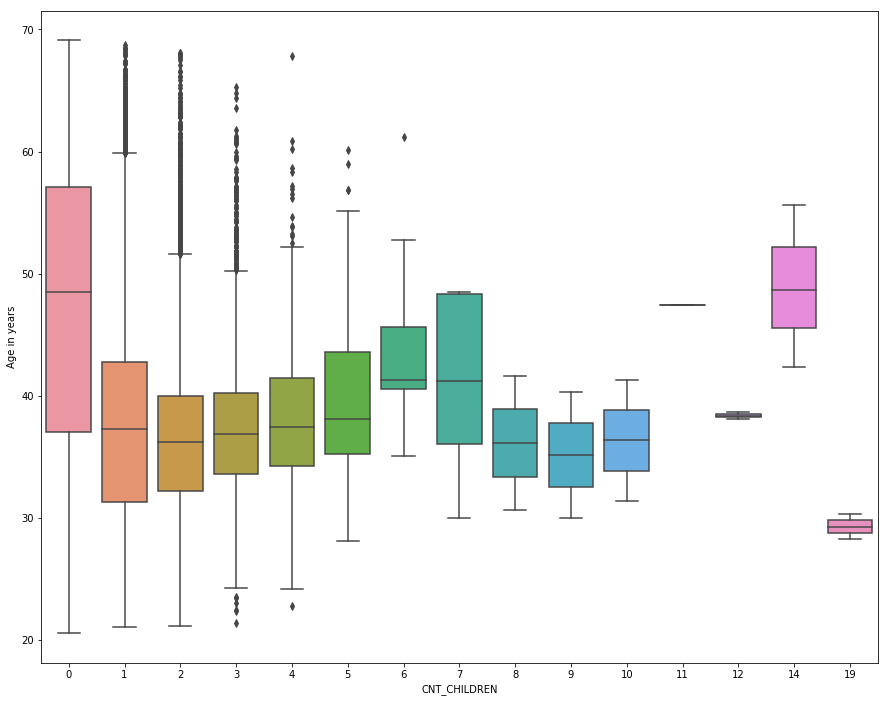

In [21]:
years_birth = -1*application_train['DAYS_BIRTH']/365
years_birth.astype(int)
fig, ax = plt.subplots(figsize = (15,12))
sns.boxplot(application_train['CNT_CHILDREN'], years_birth, ax = ax)
ax.set(xlabel='CNT_CHILDREN', ylabel='Age in years')

Those with children tend to be, on average, younger than those without children. Additionally, those without children and unable to pay back their loans make up the majority of the population:

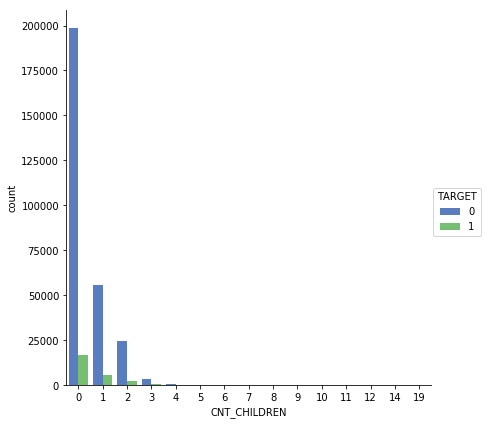

In [22]:
g = sns.factorplot(x="CNT_CHILDREN", hue="TARGET", data=application_train,
                   size=6, kind="count", palette="muted")

However, we already know that there is a class imbalance in the data between those who could/could not repay their loans

DAYS_EMPLOYED has an extremely high max so there's likely an error in recording values here:

In [23]:
application_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Text(0.5,1,'Distribution of DAYS_EMPLOYED')

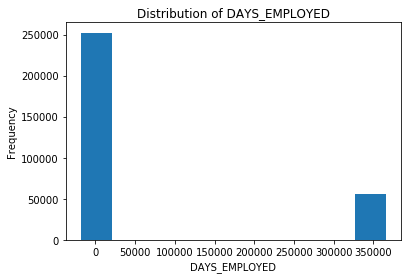

In [24]:
plt.hist(application_train['DAYS_EMPLOYED'])
plt.ylabel('Frequency')
plt.xlabel('DAYS_EMPLOYED')
plt.title('Distribution of DAYS_EMPLOYED')

365243 likely recorded instead of a missing value so lets replace this with NaN values instead but retain the values in a separate column to ensure that we can later easily find where the values were changed to NaN

Let's make these changes to the entire dataset

In [25]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [26]:
def application_train_and_test():
    
    application_train = pd.read_csv('data/application_train.csv')
    application_test = pd.read_csv('data/application_test.csv')
    
    application_train = application_train.sort_values(by = 'SK_ID_CURR')
    application_test = application_test.sort_values(by = 'SK_ID_CURR')
    df = application_train.append(application_test).reset_index()

    df['DAYS_EMPLOYED_MISS'] = df['DAYS_EMPLOYED'] == 365243
    df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

    binary_features = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
                       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION',
                       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 
                       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 
                       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
                       'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 
                       'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
                       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
                       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'DAYS_EMPLOYED_MISS']
    for feature in binary_features:
        df[feature], uniques = pd.factorize(df[feature])

    df, df_cat_col = one_hot_encoder(df)
    df = df.drop('index', axis=1)
    
    del application_train
    del application_test
    
    return df

In [27]:
df = application_train_and_test()

/anaconda3/envs/home-credit-test/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [28]:
df.head() 

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,WEEKDAY_APPR_PROCESS_START_nan
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,1,0
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,0
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,1,0
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,1,0,0,0


# 2. bureau and bureau_balance

In [29]:
bureau.columns

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')

In [30]:
bureau.head(10)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.00,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.00,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
5,215354,5714467,Active,currency 1,-273,0,27460.0,NaN,0.0,0,180000.00,71017.38,108982.62,0.0,Credit card,-31,NaN
6,215354,5714468,Active,currency 1,-43,0,79.0,NaN,0.0,0,42103.80,42103.80,0.00,0.0,Consumer credit,-22,NaN
7,162297,5714469,Closed,currency 1,-1896,0,-1684.0,-1710.0,14985.0,0,76878.45,0.00,0.00,0.0,Consumer credit,-1710,NaN
8,162297,5714470,Closed,currency 1,-1146,0,-811.0,-840.0,0.0,0,103007.70,0.00,0.00,0.0,Consumer credit,-840,NaN
9,162297,5714471,Active,currency 1,-1146,0,-484.0,NaN,0.0,0,4500.00,0.00,0.00,0.0,Credit card,-690,NaN


SK_ID_BUREAU is the ID of the loan application submitted by a person (represented by SK_ID_CURR). There are multiple loan applications under many SK_ID_CURR candidates. Let's count the amount of loan applications by each person and turn this into a new feature:

In [31]:
previous_loans = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loans'})
previous_loans.head()

,SK_ID_CURR,previous_loans
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [32]:
df = df.merge(previous_loans, on = 'SK_ID_CURR', how = 'left')
df['previous_loans'] = df['previous_loans'].fillna(0)

Similarly, CREDIT_ACTIVE denotes whether the loan is closed or still active. Let's count the number of closed and active loans associated with each individual and see if there is any correlation with the target in our training data:

In [33]:
closed_loans = bureau[bureau['CREDIT_ACTIVE'] == 'Closed']
active_loans = bureau[bureau['CREDIT_ACTIVE'] == 'Active']

closed_loans = closed_loans.groupby('SK_ID_CURR', as_index=False)['CREDIT_ACTIVE'].count().rename(columns = {'CREDIT_ACTIVE': 'closed_loans'})
active_loans = active_loans.groupby('SK_ID_CURR', as_index=False)['CREDIT_ACTIVE'].count().rename(columns = {'CREDIT_ACTIVE': 'active_loans'})

In [34]:
closed_loans.head()

,SK_ID_CURR,closed_loans
0,100001,4
1,100002,6
2,100003,3
3,100004,2
4,100005,1


In [35]:
active_loans.head()

,SK_ID_CURR,active_loans
0,100001,3
1,100002,2
2,100003,1
3,100005,2
4,100008,1


In [36]:
df = df.merge(closed_loans, on = 'SK_ID_CURR', how = 'left')
df = df.merge(active_loans, on = 'SK_ID_CURR', how = 'left')

df['closed_loans'] = df['closed_loans'].fillna(0)
df['active_loans'] = df['active_loans'].fillna(0)

In [37]:
del bureau['CREDIT_ACTIVE']

In [38]:
df.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,WEEKDAY_APPR_PROCESS_START_nan,previous_loans,closed_loans,active_loans
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,1,0,8.0,6.0,2.0
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,4.0,3.0,1.0
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,2.0,2.0,0.0
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0.0,0.0,0.0
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,1.0,1.0,0.0


In [39]:
bureau.AMT_CREDIT_SUM_OVERDUE.describe()

count    1.716428e+06
mean     3.791276e+01
std      5.937650e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.756681e+06
Name: AMT_CREDIT_SUM_OVERDUE, dtype: float64

In [40]:
bureau['CREDIT_CURRENCY'].value_counts()

currency 1    1715020
currency 2       1224
currency 3        174
currency 4         10
Name: CREDIT_CURRENCY, dtype: int64

The currency for the loans is heavily biased towards currency 1. We will one-hot encode this feature along with others and add it to our training and testing data

In [41]:
bureau.DAYS_CREDIT.describe()

count    1.716428e+06
mean    -1.142108e+03
std      7.951649e+02
min     -2.922000e+03
25%     -1.666000e+03
50%     -9.870000e+02
75%     -4.740000e+02
max      0.000000e+00
Name: DAYS_CREDIT, dtype: float64

This looks reasonable

In [42]:
bureau, bureau_cat_cols = one_hot_encoder(bureau)

bureau_balance, bureau_balance_cat_cols = one_hot_encoder(bureau_balance)

In [43]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,CREDIT_TYPE_nan
0,215354,5714462,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,215354,5714463,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,...,0,0,0,0,0,0,0,0,0,0
2,215354,5714464,-203,0,528.0,NaN,NaN,0,464323.5,NaN,...,0,0,0,0,0,0,0,0,0,0
3,215354,5714465,-203,0,NaN,NaN,NaN,0,90000.0,NaN,...,0,0,0,0,0,0,0,0,0,0
4,215354,5714466,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,...,0,0,0,0,0,0,0,0,0,0


Take the min, max, and mean of all the numerical features related to each loan by each SK_ID_CURR and make them new features to merge into train and test sets

In [44]:
bureau_agg = bureau.groupby('SK_ID_CURR').agg({'DAYS_CREDIT':['min', 'max', 'mean'],
                                               'CREDIT_DAY_OVERDUE':['max', 'mean'],
                                               'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
                                               'DAYS_ENDDATE_FACT': ['mean'],
                                               'AMT_CREDIT_MAX_OVERDUE': ['mean'],
                                               'CNT_CREDIT_PROLONG': ['count'],
                                               'AMT_CREDIT_SUM': ['min', 'max', 'mean'],
                                               'AMT_CREDIT_SUM_DEBT': ['min', 'max', 'mean'],
                                               'AMT_CREDIT_SUM_LIMIT': ['sum', 'mean'],
                                               'AMT_CREDIT_SUM_OVERDUE': ['mean'],
                                               'DAYS_CREDIT_UPDATE': ['min', 'max', 'mean'],
                                               'AMT_ANNUITY': ['max', 'mean']})

bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

In [45]:
bureau_agg.head()

,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_ENDDATE_FACT_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,...,BURO_AMT_CREDIT_SUM_DEBT_MAX,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_AMT_CREDIT_SUM_LIMIT_MEAN,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_DAYS_CREDIT_UPDATE_MIN,BURO_DAYS_CREDIT_UPDATE_MAX,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_AMT_ANNUITY_MAX,BURO_AMT_ANNUITY_MEAN
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.000000,0,0.0,-1329.0,1778.0,82.428571,-825.500000,NaN,...,373239.0,85240.928571,0.000,0.00000,0.0,-155,-6,-93.142857,10822.5,3545.357143
100002,-1437,-103,-874.000000,0,0.0,-1072.0,780.0,-349.000000,-697.500000,1681.029,...,245781.0,49156.200000,31988.565,7997.14125,0.0,-1185,-7,-499.875000,0.0,0.000000
100003,-2586,-606,-1400.750000,0,0.0,-2434.0,1216.0,-544.500000,-1097.333333,0.000,...,0.0,0.000000,810000.000,202500.00000,0.0,-2131,-43,-816.000000,NaN,NaN
100004,-1326,-408,-867.000000,0,0.0,-595.0,-382.0,-488.500000,-532.500000,0.000,...,0.0,0.000000,0.000,0.00000,0.0,-682,-382,-532.000000,NaN,NaN
100005,-373,-62,-190.666667,0,0.0,-128.0,1324.0,439.333333,-123.000000,0.000,...,543087.0,189469.500000,0.000,0.00000,0.0,-121,-11,-54.333333,4261.5,1420.500000


In [46]:
df = df.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

In [47]:
df.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,BURO_AMT_CREDIT_SUM_DEBT_MAX,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_AMT_CREDIT_SUM_LIMIT_MEAN,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_DAYS_CREDIT_UPDATE_MIN,BURO_DAYS_CREDIT_UPDATE_MAX,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_AMT_ANNUITY_MAX,BURO_AMT_ANNUITY_MEAN
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,245781.0,49156.2,31988.565,7997.14125,0.0,-1185.0,-7.0,-499.875,0.0,0.0
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,810000.000,202500.00000,0.0,-2131.0,-43.0,-816.000,NaN,NaN
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.00000,0.0,-682.0,-382.0,-532.000,NaN,NaN
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.00000,0.0,-783.0,-783.0,-783.000,NaN,NaN


Aggregate features of bureau_balance, join them to bureau table and merge features into train and test:

In [48]:
bureau_balance_and_bureau = bureau.merge(bureau_balance, on = 'SK_ID_BUREAU', how = 'left')

In [49]:
bureau_balance_and_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,...,MONTHS_BALANCE,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,STATUS_nan
0,215354,5714462,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,5714463,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,-203,0,528.0,NaN,NaN,0,464323.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,-203,0,NaN,NaN,NaN,0,90000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
bureau_balance_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}

for col in bureau_balance_cat_cols:
    bureau_balance_aggregations[col] = ['mean']

bureau_balance_agg = bureau_balance_and_bureau.groupby('SK_ID_CURR').agg(bureau_balance_aggregations)

bureau_balance_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bureau_balance_agg.columns.tolist()])

In [51]:
bureau_balance_agg.head()

,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN,STATUS_nan_MEAN
SK_ID_CURR,,,,,,,,,,,,
100001,-51.0,0.0,172,0.180233,0.005814,0.0,0.0,0.0,0.0,0.639535,0.174419,0.0
100002,-47.0,0.0,110,0.409091,0.245455,0.0,0.0,0.0,0.0,0.209091,0.136364,0.0
100003,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005,-12.0,0.0,21,0.666667,0.000000,0.0,0.0,0.0,0.0,0.238095,0.095238,0.0


Set size to NaN e.g. in the scenario where a lone applicant has 4 separate loans with no MONTHS_BALANCE information (paid back in that month presumably), the size of MONTHS_BALANCE will be set to NaN instead of 4

In [52]:
for row in range(len(bureau_balance_agg)):
    if np.isnan(bureau_balance_agg.iloc[row, 0]) == True and np.isnan(bureau_balance_agg.iloc[row, 1]) == True:
        bureau_balance_agg.iloc[row, 2] = np.nan

Merge these aggregated features into train and test

In [53]:
df = df.merge(bureau_balance_agg, on = 'SK_ID_CURR', how = 'left')

In [54]:
df.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,MONTHS_BALANCE_SIZE,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN,STATUS_nan_MEAN
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,110.0,0.409091,0.245455,0.0,0.0,0.0,0.0,0.209091,0.136364,0.0
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
missing_value_counter(df)

The following features are missing values: 

AMT_ANNUITY missing value counts: 36, 0.00010% of column missing
AMT_GOODS_PRICE missing value counts: 278, 0.00078% of column missing
AMT_REQ_CREDIT_BUREAU_DAY missing value counts: 47568, 0.13352% of column missing
AMT_REQ_CREDIT_BUREAU_HOUR missing value counts: 47568, 0.13352% of column missing
AMT_REQ_CREDIT_BUREAU_MON missing value counts: 47568, 0.13352% of column missing
AMT_REQ_CREDIT_BUREAU_QRT missing value counts: 47568, 0.13352% of column missing
AMT_REQ_CREDIT_BUREAU_WEEK missing value counts: 47568, 0.13352% of column missing
AMT_REQ_CREDIT_BUREAU_YEAR missing value counts: 47568, 0.13352% of column missing
APARTMENTS_AVG missing value counts: 179948, 0.50511% of column missing
APARTMENTS_MEDI missing value counts: 179948, 0.50511% of column missing
APARTMENTS_MODE missing value counts: 179948, 0.50511% of column missing
BASEMENTAREA_AVG missing value counts: 207584, 0.58268% of column missing
BASEMENTAREA_MEDI missing value c

In [56]:
print(np.shape(df))

(356255, 299)


# 3. credit_card_balance

In [57]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [58]:
missing_value_counter(credit_card_balance)

The following features are missing values: 

AMT_DRAWINGS_ATM_CURRENT missing value counts: 749816, 0.19525% of column missing
AMT_DRAWINGS_OTHER_CURRENT missing value counts: 749816, 0.19525% of column missing
AMT_DRAWINGS_POS_CURRENT missing value counts: 749816, 0.19525% of column missing
AMT_INST_MIN_REGULARITY missing value counts: 305236, 0.07948% of column missing
AMT_PAYMENT_CURRENT missing value counts: 767988, 0.19998% of column missing
CNT_DRAWINGS_ATM_CURRENT missing value counts: 749816, 0.19525% of column missing
CNT_DRAWINGS_OTHER_CURRENT missing value counts: 749816, 0.19525% of column missing
CNT_DRAWINGS_POS_CURRENT missing value counts: 749816, 0.19525% of column missing
CNT_INSTALMENT_MATURE_CUM missing value counts: 305236, 0.07948% of column missing


In [59]:
print(np.shape(credit_card_balance))

(3840312, 23)


In [60]:
credit_card_balance[credit_card_balance['SK_ID_CURR'] == 378907].sort_values(by = 'MONTHS_BALANCE', ascending = False).head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
330701,2562384,378907,-2,28.575,9000,0.0,0.0,0.0,0.0,1916.910,...,28.575,28.575,0.0,0,0.0,0.0,39.0,Active,0,0
2070436,2562384,378907,-3,1897.875,9000,0.0,0.0,0.0,0.0,2250.000,...,1897.875,1897.875,0.0,0,0.0,0.0,38.0,Active,0,0
1548947,2562384,378907,-4,4036.860,9000,0.0,900.0,0.0,900.0,2250.000,...,4036.860,4036.860,0.0,1,0.0,1.0,37.0,Active,0,0
1821907,2562384,378907,-5,5228.280,9000,0.0,5229.0,0.0,5229.0,840.780,...,5228.280,5228.280,0.0,2,0.0,2.0,36.0,Active,0,0
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0


SK_ID_CURR 378907 had one previous credit card loan with Home-Credit and the above are monthly snapshots of this loan 

Let's create a feature that counts the no. of previous loans by each applicant. The number of months previous that the applicant took out the previous loan (SK_ID_PREV) could also be useful.

In [61]:
prev_credit_months = credit_card_balance.groupby(['SK_ID_CURR', 'SK_ID_PREV'], as_index=False)['MONTHS_BALANCE'].count().rename(columns = {'MONTHS_BALANCE': 'prev_credit_months'})

Setting the prev_credit_months column to negative relative to current loan:

In [62]:
prev_credit_months['prev_credit_months'] = -prev_credit_months['prev_credit_months']

From this DataFrame, we can calculate the number of previous loans associated with each current applicant

In [63]:
prev_credit_months['SK_ID_CURR'].value_counts()

355767    4
206455    3
187294    3
408065    3
431517    3
263421    3
445160    3
120076    3
195593    2
187250    2
361257    2
429857    2
369073    2
365473    2
447704    2
201547    2
129132    2
208116    2
106737    2
336798    2
373644    2
149966    2
343259    2
322503    2
398334    2
245443    2
218044    2
422431    2
389623    2
341780    2
         ..
399894    1
158232    1
418329    1
162330    1
330228    1
121326    1
199092    1
379372    1
112141    1
110094    1
305600    1
303553    1
309698    1
307651    1
301510    1
324043    1
313804    1
272848    1
270801    1
276946    1
293338    1
279005    1
285150    1
373219    1
362980    1
367078    1
125416    1
129514    1
389611    1
268291    1
Name: SK_ID_CURR, Length: 103558, dtype: int64

In [64]:
previous_credit_loans = pd.DataFrame()
previous_credit_loans['SK_ID_CURR'] = prev_credit_months['SK_ID_CURR'].value_counts().index.values
previous_credit_loans['previous_credit_loans'] = prev_credit_months['SK_ID_CURR'].value_counts().values
previous_credit_loans.head()

,SK_ID_CURR,previous_credit_loans
0,355767,4
1,206455,3
2,187294,3
3,408065,3
4,431517,3


In [65]:
df = df.merge(previous_credit_loans, on = 'SK_ID_CURR', how = 'left')
df['previous_credit_loans'] = df['previous_credit_loans'].fillna(0)

In [66]:
df.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN,STATUS_nan_MEAN,previous_credit_loans
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.409091,0.245455,0.0,0.0,0.0,0.0,0.209091,0.136364,0.0,0.0
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


## Number of loans of different status per SK_ID_CURR

In [67]:
current_loan_status = credit_card_balance[['SK_ID_CURR', 'SK_ID_PREV', 'NAME_CONTRACT_STATUS']].sort_values(by = ['SK_ID_CURR', 'NAME_CONTRACT_STATUS']).drop_duplicates()

In [68]:
current_loan_status.NAME_CONTRACT_STATUS.value_counts()

Active           104206
Completed         13295
Signed             4930
Sent proposal       513
Demand               22
Refused              17
Approved              5
Name: NAME_CONTRACT_STATUS, dtype: int64

Looking only at Active and Completed loans:

In [69]:
current_loan_status = current_loan_status[current_loan_status['NAME_CONTRACT_STATUS'].isin(['Active', 'Completed'])]

### Completed loans

In [70]:
prev_credit_completed = current_loan_status[current_loan_status['NAME_CONTRACT_STATUS'] == 'Completed']
prev_credit_completed = pd.get_dummies(prev_credit_completed)

del prev_credit_completed['SK_ID_PREV']

prev_credit_completed.head()

,SK_ID_CURR,NAME_CONTRACT_STATUS_Completed
538219,100021,1
3499,100059,1
170230,100109,1
95083,100112,1
684469,100128,1


In [71]:
prev_credit_completed = prev_credit_completed.groupby('SK_ID_CURR', as_index=False)['NAME_CONTRACT_STATUS_Completed'].count()

In [72]:
df = df.merge(prev_credit_completed, on = 'SK_ID_CURR', how = 'left')
df['NAME_CONTRACT_STATUS_Completed'] = df['NAME_CONTRACT_STATUS_Completed'].fillna(0)

In [73]:
df.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN,STATUS_nan_MEAN,previous_credit_loans,NAME_CONTRACT_STATUS_Completed
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.245455,0.0,0.0,0.0,0.0,0.209091,0.136364,0.0,0.0,0.0
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


### Active loans

In [74]:
prev_credit_active = current_loan_status.drop_duplicates(subset = ['SK_ID_CURR', 'SK_ID_PREV'], keep = False)
prev_credit_active = prev_credit_active[prev_credit_active['NAME_CONTRACT_STATUS'] == 'Active']
prev_credit_active = pd.get_dummies(prev_credit_active)

del prev_credit_active['SK_ID_PREV']

prev_credit_active.head()

,SK_ID_CURR,NAME_CONTRACT_STATUS_Active
520387,100006,1
35799,100011,1
14753,100013,1
778090,100023,1
62934,100028,1


In [75]:
prev_credit_active = prev_credit_active.groupby('SK_ID_CURR', as_index=False)['NAME_CONTRACT_STATUS_Active'].count()

df = df.merge(prev_credit_active, on = 'SK_ID_CURR', how = 'left')
df['NAME_CONTRACT_STATUS_Active'] = df['NAME_CONTRACT_STATUS_Active'].fillna(0)

In [76]:
df.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN,STATUS_nan_MEAN,previous_credit_loans,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Active
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.209091,0.136364,0.0,0.0,0.0,0.0
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


### Creating aggregate features from numerical columns in credit_card_balance and merging into train and test

In [77]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [78]:
credit_card_balance.dtypes

SK_ID_PREV                      int64
SK_ID_CURR                      int64
MONTHS_BALANCE                  int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL         int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT            int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS           object
SK_DPD                          int64
SK_DPD_DEF                      int64
dtype: object

In [80]:
credit_card_balance.drop(columns = ['NAME_CONTRACT_STATUS', 'SK_ID_PREV'], inplace = True)
cc_agg = credit_card_balance.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
df = df.merge(cc_agg, on = 'SK_ID_CURR', how = 'left')

In [81]:
df.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4. installments_payments

In [82]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [83]:
np.shape(installments_payments)

(13605401, 8)

In [84]:
missing_value_counter(installments_payments)

The following features are missing values: 

DAYS_ENTRY_PAYMENT missing value counts: 2905, 0.00021% of column missing
AMT_PAYMENT missing value counts: 2905, 0.00021% of column missing


In [85]:
installments_payments.sort_values(by = ['SK_ID_CURR', 'SK_ID_PREV']).head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
1478621,1369693,100001,1.0,1,-1709.0,-1715.0,3951.00,3951.00
2568722,1369693,100001,1.0,2,-1679.0,-1715.0,3951.00,3951.00
2624024,1369693,100001,2.0,4,-1619.0,-1628.0,17397.90,17397.90
3458712,1369693,100001,1.0,3,-1649.0,-1660.0,3951.00,3951.00
1761012,1851984,100001,1.0,2,-2916.0,-2916.0,3982.05,3982.05


### Mean no. of days it took each applicant to pay installments on previous loans

In [86]:
installments_day_diff = installments_payments.sort_values(by = ['SK_ID_CURR', 'SK_ID_PREV'])[['SK_ID_CURR', 'SK_ID_PREV', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT']]
installments_day_diff['installments_day_diff'] = installments_day_diff['DAYS_INSTALMENT'] - installments_day_diff['DAYS_ENTRY_PAYMENT']
installments_day_diff_agg = installments_day_diff.groupby(['SK_ID_CURR', 'SK_ID_PREV'], as_index=False)['installments_day_diff'].mean()

In [87]:
del installments_day_diff_agg['SK_ID_PREV']

In [88]:
installments_day_diff_agg = installments_day_diff_agg.groupby('SK_ID_CURR', as_index=False)['installments_day_diff'].mean()

In [89]:
installments_day_diff_agg.head()

,SK_ID_CURR,installments_day_diff
0,100001,5.916667
1,100002,20.421053
2,100003,7.448413
3,100004,7.666667
4,100005,23.555556


In [90]:
df = df.merge(installments_day_diff_agg, on = 'SK_ID_CURR', how = 'left')

In [91]:
df.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,installments_day_diff
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.421053
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.448413
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.666667
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.300000
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.887220


In [92]:
del installments_payments['DAYS_INSTALMENT']
del installments_payments['DAYS_ENTRY_PAYMENT']

In [93]:
installments_payments.sort_values(by = ['SK_ID_CURR', 'SK_ID_PREV']).head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,AMT_INSTALMENT,AMT_PAYMENT
1478621,1369693,100001,1.0,1,3951.00,3951.00
2568722,1369693,100001,1.0,2,3951.00,3951.00
2624024,1369693,100001,2.0,4,17397.90,17397.90
3458712,1369693,100001,1.0,3,3951.00,3951.00
1761012,1851984,100001,1.0,2,3982.05,3982.05


### Mean difference between installment amount and what was actually paid each month

In [94]:
installments_diff = installments_payments.sort_values(by = ['SK_ID_CURR', 'SK_ID_PREV'])[['SK_ID_CURR', 'SK_ID_PREV', 'AMT_INSTALMENT', 'AMT_PAYMENT']]
installments_diff['installments_diff'] = installments_diff['AMT_INSTALMENT'] - installments_diff['AMT_PAYMENT']
installments_diff_agg = installments_diff.groupby(['SK_ID_CURR', 'SK_ID_PREV'], as_index=False)['installments_diff'].mean()

In [95]:
installments_diff_agg.head()

,SK_ID_CURR,SK_ID_PREV,installments_diff
0,100001,1369693,0.0
1,100001,1851984,0.0
2,100002,1038818,0.0
3,100003,1810518,0.0
4,100003,2396755,0.0


In [96]:
del installments_diff_agg['SK_ID_PREV']

In [97]:
installments_diff_agg.head()

,SK_ID_CURR,installments_diff
0,100001,0.0
1,100001,0.0
2,100002,0.0
3,100003,0.0
4,100003,0.0


In [98]:
installments_diff_agg = installments_diff_agg.groupby('SK_ID_CURR', as_index=False)['installments_diff'].mean()

In [99]:
installments_diff_agg.head()

,SK_ID_CURR,installments_diff
0,100001,0.0
1,100002,0.0
2,100003,0.0
3,100004,0.0
4,100005,0.0


In [100]:
df = df.merge(installments_diff_agg, on = 'SK_ID_CURR', how = 'left')

In [101]:
df.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,installments_day_diff,installments_diff
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.421053,0.000000
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.448413,0.000000
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.666667,0.000000
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.300000,0.000000
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.887220,451.455527


# 5. POS_CASH_balance

In [102]:
POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [103]:
prev_POS_months = POS_CASH_balance.groupby(['SK_ID_CURR', 'SK_ID_PREV'], as_index=False)['MONTHS_BALANCE'].count().rename(columns = {'MONTHS_BALANCE': 'prev_POS_months'})

In [104]:
prev_POS_months.sort_values(by = ['SK_ID_CURR', 'SK_ID_PREV']).head(20)

,SK_ID_CURR,SK_ID_PREV,prev_POS_months
0,100001,1369693,5
1,100001,1851984,4
2,100002,1038818,19
3,100003,1810518,8
4,100003,2396755,12
5,100003,2636178,8
6,100004,1564014,4
7,100005,2495675,11
8,100006,2078043,3
9,100006,2190416,10


Setting the prev_POS_months column to negative relative to current loan:

In [105]:
prev_POS_months['prev_POS_months'] = -prev_POS_months['prev_POS_months']

In [106]:
prev_POS_months.head()

,SK_ID_CURR,SK_ID_PREV,prev_POS_months
0,100001,1369693,-5
1,100001,1851984,-4
2,100002,1038818,-19
3,100003,1810518,-8
4,100003,2396755,-12


From this DataFrame, we can calculate the number of previous loans associated with each current applicant

In [107]:
prev_POS_months['SK_ID_CURR'].value_counts()

309133    26
152214    24
272099    23
197583    23
328085    22
122102    21
265240    21
261121    21
307985    21
421897    20
156668    20
390000    20
380425    20
265588    20
265042    20
426540    20
395125    20
147206    19
111885    19
435533    19
203304    19
293823    19
192587    19
450053    19
267366    19
253325    19
189332    19
382378    19
126272    19
200492    19
          ..
173824     1
268296     1
161562     1
261931     1
276492     1
311315     1
325652     1
323605     1
321558     1
319511     1
301080     1
299033     1
151325     1
149276     1
163611     1
139031     1
169734     1
143121     1
346146     1
344099     1
358436     1
141072     1
188175     1
352295     1
184077     1
194314     1
327723     1
192265     1
171783     1
225055     1
Name: SK_ID_CURR, Length: 337252, dtype: int64

In [108]:
previous_POS_loans = pd.DataFrame()
previous_POS_loans['SK_ID_CURR'] = prev_POS_months['SK_ID_CURR'].value_counts().index.values
previous_POS_loans['previous_POS_loans'] = prev_POS_months['SK_ID_CURR'].value_counts().values
previous_POS_loans.head()

,SK_ID_CURR,previous_POS_loans
0,309133,26
1,152214,24
2,272099,23
3,197583,23
4,328085,22


In [109]:
df = df.merge(previous_POS_loans, on = 'SK_ID_CURR', how = 'left')

In [110]:
df['previous_POS_loans'] = df['previous_POS_loans'].fillna(0)

In [111]:
df.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,installments_day_diff,installments_diff,previous_POS_loans
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.421053,0.000000,1.0
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.448413,0.000000,3.0
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.666667,0.000000,1.0
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.300000,0.000000,3.0
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.887220,451.455527,5.0


In [112]:
POS_CASH_balance.sort_values(by = ['SK_ID_CURR', 'SK_ID_PREV']).head(10)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
2197888,1369693,100001,-53,4.0,0.0,Completed,0,0
4704415,1369693,100001,-54,4.0,1.0,Active,0,0
7167007,1369693,100001,-57,4.0,4.0,Active,0,0
7823681,1369693,100001,-55,4.0,2.0,Active,0,0
8789081,1369693,100001,-56,4.0,3.0,Active,0,0
1261679,1851984,100001,-96,4.0,2.0,Active,0,0
1891462,1851984,100001,-95,4.0,1.0,Active,7,7
4928574,1851984,100001,-93,4.0,0.0,Completed,0,0
8531326,1851984,100001,-94,4.0,0.0,Active,0,0
513222,1038818,100002,-13,24.0,18.0,Active,0,0


In [113]:
current_POS_status = POS_CASH_balance[['SK_ID_CURR', 'SK_ID_PREV', 'NAME_CONTRACT_STATUS']].sort_values(by = ['SK_ID_CURR', 'NAME_CONTRACT_STATUS']).drop_duplicates()

In [114]:
current_POS_status.head(10)

,SK_ID_CURR,SK_ID_PREV,NAME_CONTRACT_STATUS
1261679,100001,1851984,Active
4704415,100001,1369693,Active
2197888,100001,1369693,Completed
4928574,100001,1851984,Completed
513222,100002,1038818,Active
152816,100003,2396755,Active
367237,100003,2636178,Active
1248580,100003,1810518,Active
5467865,100003,1810518,Completed
6030254,100003,2636178,Completed


In [115]:
current_POS_status.NAME_CONTRACT_STATUS.value_counts()

Active                   932394
Completed                698704
Signed                    78383
Returned to the store      5123
Approved                   4657
Demand                      368
Amortized debt               17
Canceled                     15
XNA                           2
Name: NAME_CONTRACT_STATUS, dtype: int64

Looking only at Active and Completed loans:

In [116]:
current_POS_status = current_POS_status[current_POS_status['NAME_CONTRACT_STATUS'].isin(['Active', 'Completed'])]

In [117]:
current_POS_status.head()

,SK_ID_CURR,SK_ID_PREV,NAME_CONTRACT_STATUS
1261679,100001,1851984,Active
4704415,100001,1369693,Active
2197888,100001,1369693,Completed
4928574,100001,1851984,Completed
513222,100002,1038818,Active


### Completed loans

In [118]:
prev_POS_completed = current_POS_status[current_POS_status['NAME_CONTRACT_STATUS'] == 'Completed']
prev_POS_completed = pd.get_dummies(prev_POS_completed)

del prev_POS_completed['SK_ID_PREV']

prev_POS_completed.head()

,SK_ID_CURR,NAME_CONTRACT_STATUS_Completed
2197888,100001,1
4928574,100001,1
5467865,100003,1
6030254,100003,1
2446580,100004,1


In [119]:
prev_POS_completed = prev_POS_completed.rename(columns = {'NAME_CONTRACT_STATUS_Completed': 'NAME_CONTRACT_STATUS_Completed_POS'})

In [120]:
prev_POS_completed = prev_POS_completed.groupby('SK_ID_CURR', as_index=False)['NAME_CONTRACT_STATUS_Completed_POS'].count()

In [121]:
df = df.merge(prev_POS_completed, on = 'SK_ID_CURR', how = 'left')

In [122]:
df.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,installments_day_diff,installments_diff,previous_POS_loans,NAME_CONTRACT_STATUS_Completed_POS
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,20.421053,0.000000,1.0,NaN
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,7.448413,0.000000,3.0,2.0
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,7.666667,0.000000,1.0,1.0
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,25.300000,0.000000,3.0,2.0
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2.887220,451.455527,5.0,3.0


In [123]:
df['NAME_CONTRACT_STATUS_Completed_POS'] = df['NAME_CONTRACT_STATUS_Completed_POS'].fillna(0)

In [124]:
df.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,installments_day_diff,installments_diff,previous_POS_loans,NAME_CONTRACT_STATUS_Completed_POS
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,20.421053,0.000000,1.0,0.0
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,7.448413,0.000000,3.0,2.0
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,7.666667,0.000000,1.0,1.0
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,25.300000,0.000000,3.0,2.0
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2.887220,451.455527,5.0,3.0


### Active loans

In [125]:
prev_POS_active = current_POS_status.drop_duplicates(subset = ['SK_ID_CURR', 'SK_ID_PREV'], keep = False)
prev_POS_active = prev_POS_active[prev_POS_active['NAME_CONTRACT_STATUS'] == 'Active']
prev_POS_active = pd.get_dummies(prev_POS_active)

del prev_POS_active['SK_ID_PREV']

prev_POS_active.head()

,SK_ID_CURR,NAME_CONTRACT_STATUS_Active
513222,100002,1
152816,100003,1
6407345,100006,1
22511,100007,1
76767,100007,1


In [126]:
prev_POS_active = prev_POS_active.rename(columns = {'NAME_CONTRACT_STATUS_Active': 'NAME_CONTRACT_STATUS_Active_POS'})

In [127]:
prev_POS_active = prev_POS_active.groupby('SK_ID_CURR', as_index=False)['NAME_CONTRACT_STATUS_Active_POS'].count()

In [128]:
df = df.merge(prev_POS_active, on = 'SK_ID_CURR', how = 'left')

In [129]:
df['NAME_CONTRACT_STATUS_Active_POS'] = df['NAME_CONTRACT_STATUS_Active_POS'].fillna(0)

In [130]:
df.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,installments_day_diff,installments_diff,previous_POS_loans,NAME_CONTRACT_STATUS_Completed_POS,NAME_CONTRACT_STATUS_Active_POS
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,20.421053,0.000000,1.0,0.0,1.0
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,7.448413,0.000000,3.0,2.0,1.0
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,7.666667,0.000000,1.0,1.0,0.0
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,25.300000,0.000000,3.0,2.0,1.0
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,2.887220,451.455527,5.0,3.0,2.0


### Creating aggregate features from numerical columns in POS_CASH_balance and merging into train and test

In [131]:
POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [132]:
POS_CASH_balance.dtypes

SK_ID_PREV                 int64
SK_ID_CURR                 int64
MONTHS_BALANCE             int64
CNT_INSTALMENT           float64
CNT_INSTALMENT_FUTURE    float64
NAME_CONTRACT_STATUS      object
SK_DPD                     int64
SK_DPD_DEF                 int64
dtype: object

In [133]:
POS_CASH_balance.drop(columns = ['NAME_CONTRACT_STATUS', 'SK_ID_PREV'], inplace = True)

In [134]:
POS_CASH_balance.sort_values(by = ['SK_ID_CURR']).head(20)

,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
8531326,100001,-94,4.0,0.0,0,0
1891462,100001,-95,4.0,1.0,7,7
8789081,100001,-56,4.0,3.0,0,0
4704415,100001,-54,4.0,1.0,0,0
7167007,100001,-57,4.0,4.0,0,0
4928574,100001,-93,4.0,0.0,0,0
1261679,100001,-96,4.0,2.0,0,0
7823681,100001,-55,4.0,2.0,0,0
2197888,100001,-53,4.0,0.0,0,0
9849444,100002,-15,24.0,20.0,0,0


In [135]:
POS_CASH_balance_agg = POS_CASH_balance.groupby('SK_ID_CURR').agg(['min', 'max', 'mean'])

In [136]:
POS_CASH_balance_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in POS_CASH_balance_agg.columns.tolist()])

In [137]:
df = df.merge(POS_CASH_balance_agg, on = 'SK_ID_CURR', how = 'left')

In [138]:
df.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,POS_CNT_INSTALMENT_MEAN,POS_CNT_INSTALMENT_FUTURE_MIN,POS_CNT_INSTALMENT_FUTURE_MAX,POS_CNT_INSTALMENT_FUTURE_MEAN,POS_SK_DPD_MIN,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MIN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,24.000000,6.0,24.0,15.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.107143,0.0,12.0,5.785714,0.0,0.0,0.0,0.0,0.0,0.0
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.750000,0.0,4.0,2.250000,0.0,0.0,0.0,0.0,0.0,0.0
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,12.000000,0.0,48.0,8.650000,0.0,0.0,0.0,0.0,0.0,0.0
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.333333,0.0,24.0,8.969697,0.0,0.0,0.0,0.0,0.0,0.0


# 6. previous_application

In [139]:
previous_application = pd.read_csv('data/previous_application.csv')

In [140]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [141]:
previous_application.dtypes

SK_ID_PREV                       int64
SK_ID_CURR                       int64
NAME_CONTRACT_TYPE              object
AMT_ANNUITY                    float64
AMT_APPLICATION                float64
AMT_CREDIT                     float64
AMT_DOWN_PAYMENT               float64
AMT_GOODS_PRICE                float64
WEEKDAY_APPR_PROCESS_START      object
HOUR_APPR_PROCESS_START          int64
FLAG_LAST_APPL_PER_CONTRACT     object
NFLAG_LAST_APPL_IN_DAY           int64
RATE_DOWN_PAYMENT              float64
RATE_INTEREST_PRIMARY          float64
RATE_INTEREST_PRIVILEGED       float64
NAME_CASH_LOAN_PURPOSE          object
NAME_CONTRACT_STATUS            object
DAYS_DECISION                    int64
NAME_PAYMENT_TYPE               object
CODE_REJECT_REASON              object
NAME_TYPE_SUITE                 object
NAME_CLIENT_TYPE                object
NAME_GOODS_CATEGORY             object
NAME_PORTFOLIO                  object
NAME_PRODUCT_TYPE               object
CHANNEL_TYPE             

In [142]:
previous_application[['SK_ID_PREV', 'SK_ID_CURR',
                      'DAYS_FIRST_DRAWING','DAYS_FIRST_DUE',
                      'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE',
                      'DAYS_TERMINATION']].sort_values(['SK_ID_PREV', 'SK_ID_CURR']).head(20)

,SK_ID_PREV,SK_ID_CURR,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION
38906,1000001,158271,365243.0,-268.0,62.0,-238.0,-233.0
73676,1000002,101962,365243.0,-1600.0,-1450.0,-1510.0,-1501.0
1517084,1000003,252457,365243.0,-94.0,236.0,365243.0,365243.0
1406334,1000004,260094,365243.0,-862.0,-592.0,-682.0,-672.0
523289,1000005,176456,365243.0,-1688.0,-1418.0,-1418.0,-1415.0
1476878,1000006,427505,NaN,NaN,NaN,NaN,NaN
1102061,1000007,256657,365243.0,-123.0,27.0,365243.0,365243.0
368627,1000008,152059,365243.0,-1282.0,-1012.0,-1042.0,-1034.0
10842,1000009,343078,365243.0,-457.0,-307.0,-307.0,-305.0
1636159,1000010,377567,365243.0,-558.0,-48.0,-258.0,-256.0


Same issue with 365243.0 as seen before. Let's set all of these to NaN

In [143]:
previous_application['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
previous_application['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
previous_application['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
previous_application['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

Let's one-hot encode everything and make aggregate features from the categorical and numerical columns that result

In [144]:
previous_application[['SK_ID_PREV', 'SK_ID_CURR',
                      'NFLAG_LAST_APPL_IN_DAY','SELLERPLACE_AREA',
                      'HOUR_APPR_PROCESS_START', 'DAYS_DECISION']].sort_values(['SK_ID_PREV', 'SK_ID_CURR']).head(10)

,SK_ID_PREV,SK_ID_CURR,NFLAG_LAST_APPL_IN_DAY,SELLERPLACE_AREA,HOUR_APPR_PROCESS_START,DAYS_DECISION
38906,1000001,158271,1,70,8,-299
73676,1000002,101962,1,1780,8,-1634
1517084,1000003,252457,1,1103,13,-124
1406334,1000004,260094,1,1103,9,-893
523289,1000005,176456,1,1877,13,-1719
1476878,1000006,427505,1,12,13,-264
1102061,1000007,256657,1,70,13,-158
368627,1000008,152059,1,121,14,-1313
10842,1000009,343078,1,121,11,-488
1636159,1000010,377567,1,121,17,-588


In [145]:
num_aggregations = {'AMT_ANNUITY': ['min', 'max', 'mean'],
                    'AMT_APPLICATION': ['min', 'max', 'mean'],
                   'AMT_CREDIT': ['min', 'max', 'mean'],
                   'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
                   'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
                   'HOUR_APPR_PROCESS_START': ['mean'],
                   'NFLAG_LAST_APPL_IN_DAY': ['mean', 'size'],
                   'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
                   'RATE_INTEREST_PRIMARY': ['min', 'max', 'mean'],
                   'RATE_INTEREST_PRIVILEGED': ['min', 'max', 'mean'],
                   'DAYS_DECISION': ['min', 'max', 'mean'],
                   'CNT_PAYMENT': ['sum', 'mean']}

In [146]:
previous_application, cat_cols = one_hot_encoder(previous_application)

In [147]:
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']

In [148]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,...,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,PRODUCT_COMBINATION_nan
0,2030495,271877,1730.430,17145.0,17145.0,0.0,17145.0,15,1,0.0,...,0,0,0,0,0,1,0,0,0,0
1,2802425,108129,25188.615,607500.0,679671.0,NaN,607500.0,11,1,NaN,...,0,0,0,0,0,0,0,0,0,0
2,2523466,122040,15060.735,112500.0,136444.5,NaN,112500.0,11,1,NaN,...,0,0,0,0,0,0,0,0,0,0
3,2819243,176158,47041.335,450000.0,470790.0,NaN,450000.0,7,1,NaN,...,1,0,0,0,0,0,0,0,0,0
4,1784265,202054,31924.395,337500.0,404055.0,NaN,337500.0,9,1,NaN,...,0,0,0,0,0,0,0,0,0,0


In [149]:
prev_agg = previous_application.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

In [150]:
prev_agg.head(10)

,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_AMT_DOWN_PAYMENT_MIN,...,PREV_PRODUCT_COMBINATION_Cash X-Sell: middle_MEAN,PREV_PRODUCT_COMBINATION_POS household with interest_MEAN,PREV_PRODUCT_COMBINATION_POS household without interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry without interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile with interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN,PREV_PRODUCT_COMBINATION_POS other with interest_MEAN,PREV_PRODUCT_COMBINATION_POS others without interest_MEAN,PREV_PRODUCT_COMBINATION_nan_MEAN
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3951.000,3951.000,3951.000000,24835.5,24835.5,24835.500000,23787.0,23787.0,23787.000000,2520.00,...,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0
100002,9251.775,9251.775,9251.775000,179055.0,179055.0,179055.000000,179055.0,179055.0,179055.000000,0.00,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0
100003,6737.310,98356.995,56553.990000,68809.5,900000.0,435436.500000,68053.5,1035882.0,484191.000000,0.00,...,0.0,0.333333,0.000000,0.333333,0.0,0.000000,0.0,0.0,0.0,0.0
100004,5357.250,5357.250,5357.250000,24282.0,24282.0,24282.000000,20106.0,20106.0,20106.000000,4860.00,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0
100005,4813.200,4813.200,4813.200000,0.0,44617.5,22308.750000,0.0,40153.5,20076.750000,4464.00,...,0.0,0.000000,0.000000,0.000000,0.0,0.500000,0.0,0.0,0.0,0.0
100006,2482.920,39954.510,23651.175000,0.0,688500.0,272203.260000,0.0,906615.0,291695.500000,2693.34,...,0.0,0.111111,0.000000,0.111111,0.0,0.000000,0.0,0.0,0.0,0.0
100007,1834.290,22678.785,12278.805000,17176.5,247500.0,150530.250000,14616.0,284400.0,166638.750000,3105.00,...,0.5,0.166667,0.000000,0.000000,0.0,0.166667,0.0,0.0,0.0,0.0
100008,8019.090,25309.575,15839.696250,0.0,450000.0,155701.800000,0.0,501975.0,162767.700000,0.00,...,0.2,0.400000,0.000000,0.000000,0.0,0.200000,0.0,0.0,0.0,0.0
100009,7435.845,17341.605,10051.412143,40455.0,110160.0,76741.714286,38574.0,98239.5,70137.642857,0.00,...,0.0,0.714286,0.142857,0.000000,0.0,0.142857,0.0,0.0,0.0,0.0


In [151]:
approved = previous_application[previous_application['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APR_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])

In [152]:
prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')

In [153]:
refused = previous_application[previous_application['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REF_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])

In [154]:
prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')

In [155]:
prev_agg.head()

,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_AMT_DOWN_PAYMENT_MIN,...,REF_RATE_INTEREST_PRIMARY_MAX,REF_RATE_INTEREST_PRIMARY_MEAN,REF_RATE_INTEREST_PRIVILEGED_MIN,REF_RATE_INTEREST_PRIVILEGED_MAX,REF_RATE_INTEREST_PRIVILEGED_MEAN,REF_DAYS_DECISION_MIN,REF_DAYS_DECISION_MAX,REF_DAYS_DECISION_MEAN,REF_CNT_PAYMENT_SUM,REF_CNT_PAYMENT_MEAN
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3951.000,3951.000,3951.000,24835.5,24835.5,24835.50,23787.0,23787.0,23787.00,2520.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100002,9251.775,9251.775,9251.775,179055.0,179055.0,179055.00,179055.0,179055.0,179055.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,6737.310,98356.995,56553.990,68809.5,900000.0,435436.50,68053.5,1035882.0,484191.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,5357.250,5357.250,5357.250,24282.0,24282.0,24282.00,20106.0,20106.0,20106.00,4860.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005,4813.200,4813.200,4813.200,0.0,44617.5,22308.75,0.0,40153.5,20076.75,4464.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [156]:
df = df.merge(prev_agg, on = 'SK_ID_CURR', how = 'left')

In [157]:
df.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,REF_RATE_INTEREST_PRIMARY_MAX,REF_RATE_INTEREST_PRIMARY_MEAN,REF_RATE_INTEREST_PRIVILEGED_MIN,REF_RATE_INTEREST_PRIVILEGED_MAX,REF_RATE_INTEREST_PRIVILEGED_MEAN,REF_DAYS_DECISION_MIN,REF_DAYS_DECISION_MAX,REF_DAYS_DECISION_MEAN,REF_CNT_PAYMENT_SUM,REF_CNT_PAYMENT_MEAN
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-181.0,-181.0,-181.0,48.0,48.0
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
